In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import *
from extract_data import *
import datetime

In [2]:

dinfo = pd.read_csv("data/info.csv")
dinfo.head(10)

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train
5,0,train/ADONIS/006.jpg,ADONIS,train
6,0,train/ADONIS/007.jpg,ADONIS,train
7,0,train/ADONIS/008.jpg,ADONIS,train
8,0,train/ADONIS/009.jpg,ADONIS,train
9,0,train/ADONIS/010.jpg,ADONIS,train


In [3]:
dinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13594 entries, 0 to 13593
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   13594 non-null  int64 
 1   filepaths  13594 non-null  object
 2   labels     13594 non-null  object
 3   data set   13594 non-null  object
dtypes: int64(1), object(3)
memory usage: 424.9+ KB


<Axes: xlabel='labels'>

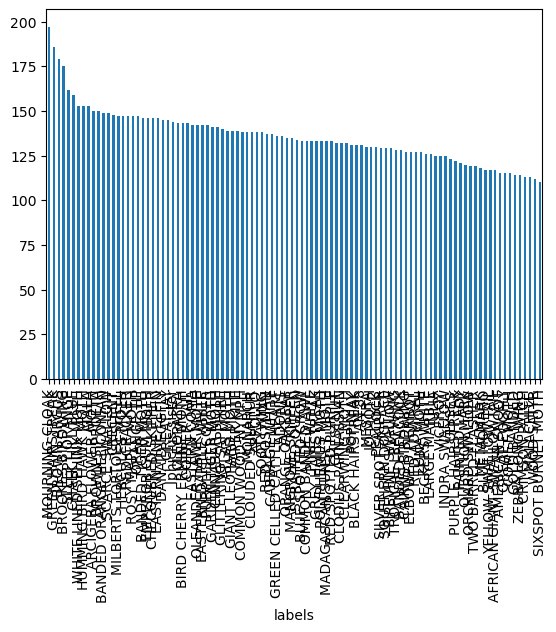

In [4]:
dinfo.labels.value_counts().plot.bar()

In [5]:
df = dinfo[dinfo["data set"] == "train"]
df

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train
...,...,...,...,...
12589,99,train/ZEBRA LONG WING/100.jpg,ZEBRA LONG WING,train
12590,99,train/ZEBRA LONG WING/101.jpg,ZEBRA LONG WING,train
12591,99,train/ZEBRA LONG WING/102.jpg,ZEBRA LONG WING,train
12592,99,train/ZEBRA LONG WING/103.jpg,ZEBRA LONG WING,train


In [6]:
X_val, Y_ab_val, y_cl_val, data_val = DataSet(stat="valid").get_data()
X_val.shape, Y_ab_val.shape, y_cl_val.shape, data_val.shape


((500, 224, 224, 1), (500, 224, 224, 2), (500, 100), (500, 224, 224, 3))

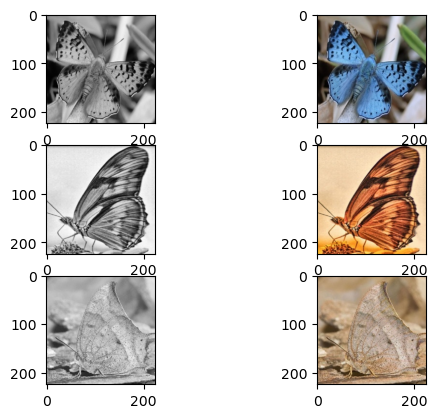

In [7]:
n = 3
fig, axs = plt.subplots(n, 2)
k = 10
for i in range(k, n + k):
    axs[i - k, 0].imshow(np.squeeze(X_val[i]), cmap="gray")
    axs[i - k, 1].imshow(np.squeeze(data_val[i]))
X_val /= 100.0

In [8]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            input_shape=(224, 224, 3),
                                            pooling='avg', classes=100,
                                            weights='imagenet')
base_model.trainable = False

inp = Input((224, 224, 1))

cl_x = Conv2D(3, (3, 3), activation='relu', padding='same')(inp * 100)  # 3 224 224
cl_x = base_model(cl_x)

hidden_dense_cl = Dense(512, "relu")(cl_x)

output_cl = Dense(100, "softmax", name="cl_img")(hidden_dense_cl)

model_cl = tf.keras.Model(inp, output_cl)
model_cl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 224, 224, 1)      0         
 a)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 cl_img (Dense)              (None, 100)               51300     
                                                             

In [9]:
class Inception(tf.keras.layers.Layer):
    def __init__(self, chanel: int, kernels: list[tuple], activation="relu", padding="same", strides=(1, 1)):
        super(Inception, self).__init__()

        self.layers = [
            Conv2D(chanel, kr, activation=activation, padding=padding, strides=strides)
            for kr in kernels
        ]
        self.Conv = Conv2D(chanel * len(kernels), (3, 3), activation=activation, padding=padding, strides=strides)

    def call(self, X):
        return self.Conv(concatenate([layer(X) for layer in self.layers]))


def concat_conv_transpose(img, x_vec, chanel, layer, kernel=(3, 3), inp2=None):
    _, s1, s2, s3 = img.shape
    n = 25088 // (s1 * s2)
    x_res = Reshape((s1, s2, n))(x_vec)
    x_res = Conv2D(x_res.shape[-1], kernel, activation="relu", padding="same")(x_res)
    if inp2 is None:
        conc = concatenate([img, x_res])
    else:
        conc = concatenate([img, x_res, inp2])

    x = Conv2DTranspose(chanel, kernel, strides=(2, 2), padding="same", activation="relu")(conc)
    return layer(x)





In [10]:

img_x = Conv2D(8, (3, 3), activation='relu', padding='same')(inp)
img_224_x = Inception(8, [(1, 1), (2, 2), (3, 3), (5, 5)])(img_x)  # 224 224 32 1.748.992

img_x = MaxPool2D((2, 2))(img_224_x)  # 112 112 32
img_x = Conv2D(32, (3, 3), activation="relu", padding="same")(img_x)
img_112_x = Inception(16, [(1, 1), (2, 2), (3, 3), (5, 5)])(img_x)  # 112 112 64 802.816

img_x = MaxPool2D((2, 2))(img_112_x)  # 56 56 64
img_x = Conv2D(64, (3, 3), activation="relu", padding="same")(img_x)
img_56_x = Inception(32, [(1, 1), (2, 2), (3, 3), (5, 5)])(img_x)  # 56 56 128 401.408

img_x = MaxPool2D((2, 2))(img_56_x)  # 28 28 128
img_x = Conv2D(128, (3, 3), activation="relu", padding="same")(img_x)
img_28_x = Inception(64, [(1, 1), (2, 2), (3, 3), (4, 4)])(img_x)  # 28 28 256 200.704

img_x = MaxPool2D((2, 2))(img_28_x)  # 14 14 256
img_x = Conv2D(256, (3, 3), activation="relu", padding="same")(img_x)
img_14_x = Inception(128, [(1, 1), (2, 2), (3, 3), (2, 2)])(img_x)  # 14 14 512 100.352

img_x = MaxPool2D((2, 2))(img_14_x)  # 7 7 512
img_x = Conv2D(512, (3, 3), activation="relu", padding="same")(img_x)
img_7_x = Inception(128, [(1, 1), (2, 2), (2, 2), (3, 3)])(img_x)  # 7 7 512 25.088

x = Dense(512, "relu")(hidden_dense_cl)
x_vec = RepeatVector(49)(x)  #25.088

l = Inception(128, [(1, 1), (2, 2), (2, 2), (3, 3)])
x = concat_conv_transpose(img_7_x, x_vec, 512, l, (3, 3), None)  # 14 14 512

l = Inception(128, [(1, 1), (2, 2), (2, 2), (3, 3)])
x = concat_conv_transpose(x, x_vec, 512, l, (3, 3), img_14_x)  # 28 28 512

l = Inception(64, [(1, 1), (2, 2), (3, 3), (4, 4)])
x = concat_conv_transpose(x, x_vec, 256, l, (3, 3), img_28_x)  # 56 56 256

l = Inception(32, [(1, 1), (2, 2), (3, 3), (5, 5)])
x = concat_conv_transpose(x, x_vec, 128, l, (3, 3), img_56_x)  # 112 112 128

l = Inception(16, [(1, 1), (2, 2), (3, 3), (5, 5)])
x = concat_conv_transpose(x, x_vec, 64, l, (3, 3), img_112_x)  # 256 256 64

x = concatenate([x, img_224_x])
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
output = Conv2D(2, (3, 3), padding="same", activation="tanh", name="img_ab")(x)

model = tf.keras.Model(inp, [output, output_cl])
model.compile(
    optimizer="adam",
    loss={"img_ab": "mse", "cl_img": "categorical_crossentropy"},
    metrics={"img_ab": "mse", "cl_img": "accuracy"}
)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 8)  80          ['input_2[0][0]']                
                                                                                                  
 inception (Inception)          (None, 224, 224, 32  11776       ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                            

 conv2d_54 (Conv2D)             (None, 28, 28, 32)   9248        ['reshape_2[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 28, 28, 800)  0           ['inception_7[0][0]',            
                                                                  'conv2d_54[0][0]',              
                                                                  'inception_3[0][0]']            
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 56, 56, 256)  1843456    ['concatenate_2[0][0]']          
 spose)                                                                                           
                                                                                                  
 reshape_3 (Reshape)            (None, 56, 56, 8)    0           ['repeat_vector[0][0]']          
          

In [11]:
class Data(tf.keras.utils.Sequence):
    def __init__(self, batch_size, max_len=-1):
        self.batch_size = batch_size
        self.gen = self._gen()
        self._len = self.calc() // batch_size

    def calc(self):
        k = 0
        for i, (_, _) in self._gen():
            k += i.shape[0]
        return k

    def _gen(self):
        for x_train, y_ab_train, y_cl_train, _ in DataSet(stat="train").gen_data(self.batch_size):
            yield (x_train / 100.0, (y_ab_train, y_cl_train))

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        try:
            return next(self.gen)
        except StopIteration:
            self.gen = self._gen()
        return next(self.gen)


In [ ]:

batch_size = 32
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="Models CL",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=batch_size)
ep = 2
ds = Data(batch_size)

h = model.fit(
    ds, batch_size=batch_size,
    epochs=20, validation_data=(X_val, (Y_ab_val, y_cl_val)),
    callbacks=[cp_callback, tensorboard_callback]
).history

Epoch 1/20


2023-06-30 18:59:50.532251: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 13/393 [..............................] - ETA: 4:43:37 - loss: 4.9004 - img_ab_loss: 0.0230 - cl_img_loss: 4.8774 - img_ab_mse: 0.0230 - cl_img_accuracy: 0.0529

In [ ]:
model.save("Model ep2.5ex.h5")  # 291 0.026 63 0.0471

In [ ]:
model.evaluate(X_val, (Y_ab_val, y_cl_val))

In [ ]:
ab, y = model.predict(X_val)

In [ ]:
ab.shape, y.shape

In [ ]:
n = 2
ab_t = ab[n].reshape(1, 224, 224, 2)
X_val_t = X_val[n].reshape(1, 224, 224, 1)

res = lab_ab_in_rgb(X_val_t, ab_t)
plt.imshow(res)

In [ ]:
plt.imshow(np.squeeze(X_val_t))